# Deutsch-Jozsa Algorithm
The Deutsch-Jozsa algorithm is a quantum algorithm that solves the Deutsch problem. Given a function $f: \{0, 1\}^n \rightarrow \{0, 1\}$, the Deutsch problem is to determine whether $f$ is constant for all inputs or balanced i.e. returns 0 for half of the inputs and 1 for the other half. The classical solution to this problem needs in the worst case $2^{n-1} + 1$ queries to the function $f$. The Deutsch-Jozsa algorithm solves this problem with only one query to the function $f$.

## Simplification - Deutsch Algorithm
The Deutsch algorithm is a simplified version of the Deutsch-Jozsa algorithm and is a good starting point to understand the Deutsch-Jozsa algorithm. The Deutsch algorithm solves the Deutsch problem for the case where $n=1$. Since the implementation of the function $f$ needs to be reversible, $f$ is implemented as a unitary operator $U_f$, that acts on two qubits, the **data qubit** and the **target qubit**. The function $f$ is implemented as follows:
$$
U_f : \ket{x}\ket{y} \rightarrow \ket{x}\ket{y \oplus f(x)}
$$
where $\oplus$ denotes addition modulo 2.

In [17]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from IPython.display import display
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_qsphere, plot_histogram

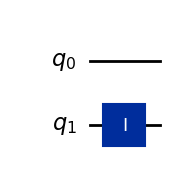

In [18]:
constant = True
constant_value = 0

oracle_qc = QuantumCircuit(2)
if constant:
    if constant_value:
        oracle_qc.x(1)
    else:
        oracle_qc.id(1)
else:
    oracle_qc.cx(0, 1)
display(oracle_qc.draw('mpl'))

oracle = oracle_qc.to_gate(label='Oracle')

### Implementation
The first step of the Deutsch algorithm is to prepare the two qubits in the state $\ket{0}\ket{1}$:
$$
\ket{\psi_1} = \ket{0}\ket{1}
$$

In [19]:
qc_deutsch = QuantumCircuit(2, 1)
qc_deutsch.x(1)
qc_deutsch.barrier()
state = Statevector(qc_deutsch)
state.reverse_qargs().draw('latex', prefix='\\ket{\\psi_1} = ')

<IPython.core.display.Latex object>

The second step is to apply the Hadamard gate $H$ to both qubits, so that the state becomes:
$$
\begin{align*}
\ket{\psi_2} &= H^{\otimes 2}\ket{\psi_1} \\
&= \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})\frac{1}{\sqrt{2}}(\ket{0} - \ket{1}) \\
&= \frac{1}{2}(\ket{0} \ket{0} - \ket{0} \ket{1} + \ket{1} \ket{0} - \ket{1} \ket{1})
\end{align*}

In [20]:
qc_deutsch.h([0, 1])
state = Statevector(qc_deutsch)
state.reverse_qargs().draw('latex', prefix='\\ket{\\psi_2} = ')

<IPython.core.display.Latex object>

Now, the Operator $U_f$ is applied to the state $\ket{\psi_2}$:
$$
\begin{align*}
\ket{\psi_3} &= U_f\ket{\psi_2} \\
&= \frac{1}{2}(U_f\ket{00} - U_f\ket{01} + U_f\ket{10} - U_f\ket{11}) \\
&= \frac{1}{2}(\ket{0, 0 \oplus f(0)} - \ket{0, 1 \oplus f(0)} + \ket{1, 0 \oplus f(1)} - \ket{1, 1 \oplus f(1)}) \\
&= \frac{1}{2}(\ket{0} \cdot (\ket{f(0)} - \ket{1 \oplus f(0)}) + \ket{1} \cdot (\ket{f(1)} - \ket{1 \oplus f(1)})) \\ 
&= \frac{1}{2} ((-1)^{f(0)}\ket{0}(\ket{0} - \ket{1}) + (-1)^{f(1)}\ket{1}(\ket{0} - \ket{1})) \\
&= \frac{1}{2} ((-1)^{f(0)}\ket{0} + (-1)^{f(1)}\ket{1})(\ket{0} - \ket{1})
\end{align*}
$$
If $f$ is constant, then $f(0) = f(1)$ and the state $\ket{\psi_3}$ becomes:
$$
\ket{\psi_3} = \frac{1}{2} (\pm (\ket{0} + \ket{1}))(\ket{0} - \ket{1})
$$
If $f$ is balanced, then $f(0) \neq f(1)$ and the state $\ket{\psi_3}$ becomes:
$$
\ket{\psi_3} = \frac{1}{2} (\pm (\ket{0} - \ket{1}))(\ket{0} - \ket{1})
$$

In [21]:
qc_deutsch.append(oracle, [0, 1])
qc_deutsch.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)), clbits=())

In the last step, the Hadamard gate $H$ is applied to the first qubit, resulting in the state for the constant function:
$$
\ket{\psi_4} = \pm \ket{0} \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right)
$$
and for the balanced function:
$$
\ket{\psi_4} = \pm \ket{1} \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right)
$$
This can be simplified to:
$$
\ket{\psi_4} = \pm \ket{f(0) \oplus f(1)} \left( \frac{\ket{0} - \ket{1}}{\sqrt{2}} \right)
$$
By measuring the first qubit, the function $f$ can be determined. If the function is constant, the first qubit will be in the state $\ket{0}$ and if the function is balanced, the first qubit will be in the state $\ket{1}$.

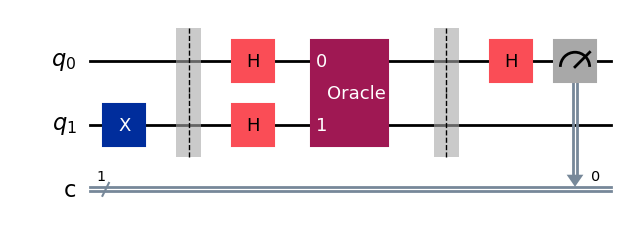

In [22]:
qc_deutsch.h(0)
qc_deutsch.measure(0, 0)
qc_deutsch.draw('mpl')

### Simulation

In [23]:
simulator = AerSimulator()
shots = 1024
sim_result = simulator.run(qc_deutsch.decompose(), shots=shots).result()

In [24]:
counts = sim_result.get_counts()
plot_histogram(counts)
if '0' in counts and counts['0'] == shots:
    print('The function is constant')
elif '1' in counts and counts['1'] == shots:
    print('The function is balanced')
else:
    print('Error') 

The function is constant
